## Tarea 2 y estudio de los ejemplos

---

In [20]:
#Agregar al path el archivo .py con la funcion para descargar
import sys
import os
sys.path.append("../.")
from utilities import download_CMI

In [21]:
#librerias utiles
import xarray as xr
import cartopy.crs as ccrs
from cartopy.feature import *
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from glob import glob

In [22]:
#directorio de trabajo crear una carpeta donde descargar imagenes y guardar plots
os.makedirs("data",exist_ok=True)
os.makedirs("plots",exist_ok=True)
!ls -l

total 5856
drwxrwxrwx 1 root root    8192 nov 10 14:12 data
drwxrwxrwx 1 root root       0 nov 10 14:46 plots
-rwxrwxrwx 1 root root 5987747 nov 13 19:47 tarea2.ipynb


In [23]:
#descargar imagenes para una fecha cualquiera
date = "202006181700" #YYYYMMDDHHMN
#Download files
bands = range(1,17)
#for band in bands:
#    #utilizar el script del taller, tambien se puede hacer un curl o wget al archivo
#    download_CMI(date, str(band), "data/") 

### Recrear ejemplo 1
---

In [24]:
band1  = "13"
band2  = "15"
image1 = xr.open_dataset(glob("data/OR_ABI-L2-CMIPF-M6C"+band1+"_G16**.nc")[0],chunks="auto")
image2 = xr.open_dataset(glob("data/OR_ABI-L2-CMIPF-M6C"+band2+"_G16**.nc")[0],chunks="auto")

In [27]:
data = (image1["CMI"]-image2["CMI"]) #compute band normalized difference

#characteristical longitude?
lon_proj_origin = image1["goes_imager_projection"].longitude_of_projection_origin
#elevation of sensor?
persp_height    = image1["goes_imager_projection"].perspective_point_height

#compute image extension
xmin = image1['x'].values.min()*persp_height
xmax = image1['x'].values.max()*persp_height
ymin = image1['y'].values.min()*persp_height
ymax = image1['y'].values.max()*persp_height
img_extent = (xmin, xmax, ymin, ymax)

In [26]:
# Define some parameters
date = pd.to_datetime("202006181700",format="%Y%m%d%H%M") #YYYYMMDDHHMN
colormap = 'Spectral' 
vmin = -7
vmax = 7

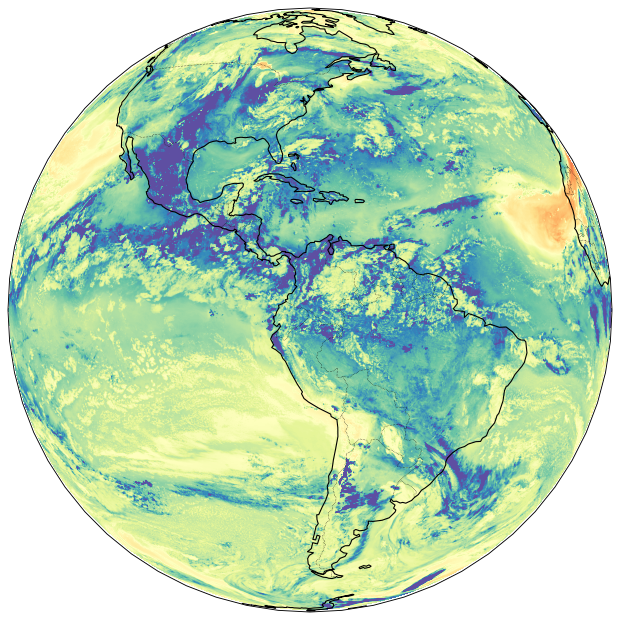

In [73]:
fig = plt.figure(figsize=(10,10))
ax  = plt.axes(projection=ccrs.Geostationary(central_longitude=lon_proj_origin,
                                             satellite_height=persp_height))

ax.coastlines()
ax.add_feature(BORDERS, edgecolor="k", lw=0.5,ls=":",zorder=10)

img = ax.imshow(data,vmin=vmin,vmax=vmax,cmap=colormap,origin="upper",extent=img_extent)

#fig.colorbar(img,label=legend,extend="both",orientation="horizontal")

In [74]:
#clear memory
del image1,image2,fig,ax,vmin,vmax,data

### Recrear ejemplo 2

---

In [61]:
#Air Mass RGB!
#Red:   diferencias entre bandas 6.2 y 7.3  -> diferencia entre bandas 8 y 10 del GOES
#       limitar esta banda a -26.2°C y 0.6°C de temperatura de brillo, esta nueva banda
#       se ha observado se un indicador de humedad en niveles altos
#Green: diferencias entre bandas 9.6 y 10.3 -> diferencia entre bandas 12 y 13 del GOES
#       limitar esta banda a -43.2°C y 6.7°C de temperatura de brillo, esta nueva banda
#       se ha observado se un indicador de la la altura de la tropopausa basado en el ozono
#Blue:  band 6.2 invertida?                 -> canal 8 dado vuelta, es decir 1-Blue
#       limitar esta banda a -29.25°C y -64.65°C de temperatura de brillo, esta nueva banda
#       se ha observado se un indicador de humedad en 500hPa -200hPa (niveles altos)
band1,band2,band3,band4 = "08","10","12","13"
img1,img2,img3,img4     = [xr.open_dataset(glob("data/OR_ABI-L2-CMIPF-M6C"+band+"_G16**.nc")[0],
                                           chunks="auto") for band in (band1,band2,band3,band4)]

#corregir las temperaturas de brillo a °C y achicar un poquito
data1,data2,data3,data4 = [im["CMI"][::4,::4]-273.15 for im in (img1,img2,img3,img4)]

#construir las bandas RGB correccion 1/gamma = 1
R = data1 - data2
G = data3 - data4
B = data1
 
#limites de temperatura de brillo
R = np.clip(R, -26.2, 0.6)
G = np.clip(G, -43.2, 6.7)
B = np.clip(B, -64.65, -29.25)
 
#correccion gamma y normalizar
R = ((R + 26.2) / (0.6 + 26.2)) ** (1/1)
G = ((G + 43.2) / (6.7 + 43.2)) ** (1/1)
B = ((B + 64.65) / (-29.25 + 64.65)) ** (1/1) 

#invertir la banda azul
B = 1.0 - B
#crear compuesto
RGB = np.stack([R, G, B], axis=2)

In [62]:
plt.figure(figsize=(10,10))
ax  = plt.axes(projection=ccrs.Geostationary(central_longitude=lon_proj_origin,
                                             satellite_height=persp_height))
ax.coastlines()
ax.add_feature(BORDERS,ls=":")

ax.imshow(RGB,origin="upper",extent=img_extent)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


---

##### Ejemplo con una diferencia de bandas y un compuesto recreados/estudiados, ahora viene la resolucion de los ejercicios de la tarea

---

# **Tarea 1: Crear la Diferencia Entre Canales - "Night Fog" (10.3 um – 3.9 um)**

Guía Rápida RAMMB:
http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_NightFogBTD.pdf

*   **Cálculo:** Canal 13 (10.3 um) - Canal 7 (3.9 um)
*   **Escala de colores sugerida:** gray
*   **Valor mínimo:** -5
*   **Valor máximo:**  5
*   **Leyenda:** Night Fog Difference
*   **Fecha:** La que desees (variable yyyymmddhhmn)



In [41]:
band1  = "13"
band2  = "07"
image1 = xr.open_dataset(glob("data/OR_ABI-L2-CMIPF-M6C"+band1+"_G16**.nc")[0],chunks="auto")
image2 = xr.open_dataset(glob("data/OR_ABI-L2-CMIPF-M6C"+band2+"_G16**.nc")[0],chunks="auto")

colormap = "Greys"
vmin = -5
vmax = 5
legend = "Night Fog Difference"
date = "202006181700" #YYYYMMDDHHMN

Text(0.0, 1.0, 'Night Fog Difference')

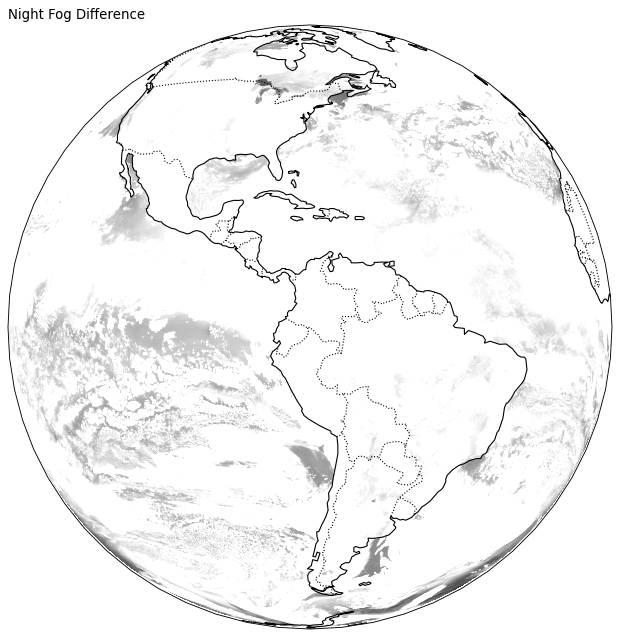

In [42]:
data=image1["CMI"]-image2["CMI"]
plt.figure(figsize=(10,10))
ax  = plt.axes(projection=ccrs.Geostationary(central_longitude=lon_proj_origin,
                                             satellite_height=persp_height))
ax.coastlines()
ax.add_feature(BORDERS,ls=":")

mapa=ax.imshow(data,origin="upper",extent=img_extent,cmap=colormap,vmin=vmin,vmax=vmax)
ax.set_title(legend,loc="left")

# **Tarea 2: Crear la Diferencia Entre Canales - "Split Cloud Phase" (11.2 um – 8.4 um)**

Guía Rápida RAMMB:
http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_G16_CloudPhaseBTD.pdf

*   **Cálculo:** Canal 14 (11.2 um) - Canal 11 (8.4 um)
*   **Escala de colores sugerida:** jet
*   **Valor mínimo:** -10
*   **Valor máximo:**  25
*   **Leyenda:** Split Cloud Phase


In [37]:
band1  = "14"
band2  = "11"
image1 = xr.open_dataset(glob("data/OR_ABI-L2-CMIPF-M6C"+band1+"_G16**.nc")[0],chunks="auto")
image2 = xr.open_dataset(glob("data/OR_ABI-L2-CMIPF-M6C"+band2+"_G16**.nc")[0],chunks="auto")

colormap = "jet"
vmin = -10
vmax = 25
legend = "Split Cloud Phase"
date = "202006181700" #YYYYMMDDHHMN

Text(0.0, 1.0, 'Split Cloud Phase')

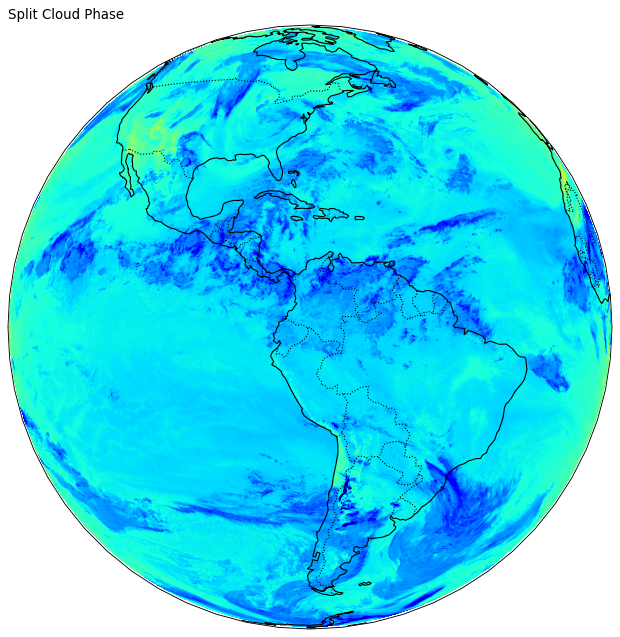

In [38]:
data=image1["CMI"]-image2["CMI"]
plt.figure(figsize=(10,10))
ax  = plt.axes(projection=ccrs.Geostationary(central_longitude=lon_proj_origin,
                                             satellite_height=persp_height))
ax.coastlines()
ax.add_feature(BORDERS,ls=":")

mapa=ax.imshow(data,origin="upper",extent=img_extent,cmap=colormap,vmin=vmin,vmax=vmax)
ax.set_title(legend,loc="left")

# **Tarea 3: Crear la Diferencia Entre Canales - "Split Water Vapor" (6.2 um – 7.3 um)**

Guía Rápida RAMMB:
http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_SplitWV_BTDiffv2.pdf

*   **Cálculo:** Canal 8 (6.2 um) - Canal 10 (7.3 um)
*   **Escala de colores sugerida:** nipy_spectral
*   **Valor mínimo:** -30
*   **Valor máximo:**  5
*   **Leyenda:** Split Water Vapor
*   **Fecha:** La que desees (variable yyyymmddhhmn)



In [46]:
band1  = "08"
band2  = "10"
image1 = xr.open_dataset(glob("data/OR_ABI-L2-CMIPF-M6C"+band1+"_G16**.nc")[0],chunks="auto")
image2 = xr.open_dataset(glob("data/OR_ABI-L2-CMIPF-M6C"+band2+"_G16**.nc")[0],chunks="auto")

colormap = "nipy_spectral"
vmin = -30
vmax = 5
legend = "Split Water Vapor"
date = "202006181700" #YYYYMMDDHHMN

Text(0.0, 1.0, 'Split Water Vapor')

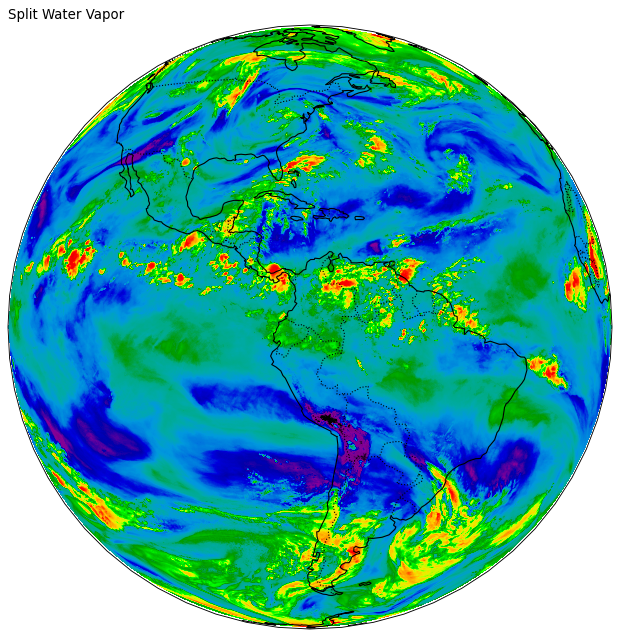

In [47]:
data=image1["CMI"]-image2["CMI"]
plt.figure(figsize=(10,10))
ax  = plt.axes(projection=ccrs.Geostationary(central_longitude=lon_proj_origin,
                                             satellite_height=persp_height))
ax.coastlines()
ax.add_feature(BORDERS,ls=":")

mapa=ax.imshow(data,origin="upper",extent=img_extent,cmap=colormap,vmin=vmin,vmax=vmax)
ax.set_title(legend,loc="left")

# **Tarea 4: Crear la Diferencia Entre Canales - "Split Ozone" (9.6 um – 10.3 um)**

Guía Rápida RAMMB:
http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_SplitOzoneDiff.pdf

*   **Cálculo:** Canal 12 (9.6 um) - Canal 13 (10.3 um)
*   **Escala de colores sugerida:** nipy_spectral
*   **Valor mínimo:** -45
*   **Valor máximo:**  5
*   **Leyenda:** Split Ozone
*   **Fecha:** La que desees (variable yyyymmddhhmn)



In [48]:
band1  = "12"
band2  = "13"
image1 = xr.open_dataset(glob("data/OR_ABI-L2-CMIPF-M6C"+band1+"_G16**.nc")[0],chunks="auto")
image2 = xr.open_dataset(glob("data/OR_ABI-L2-CMIPF-M6C"+band2+"_G16**.nc")[0],chunks="auto")

colormap = "nipy_spectral"
vmin = -45
vmax = 5
legend = "Split Ozone"
date = "202006181700" #YYYYMMDDHHMN

In [49]:
data=image1["CMI"]-image2["CMI"]
plt.figure(figsize=(10,10))
ax  = plt.axes(projection=ccrs.Geostationary(central_longitude=lon_proj_origin,
                                             satellite_height=persp_height))
ax.coastlines()
ax.add_feature(BORDERS,ls=":")

mapa=ax.imshow(data,origin="upper",extent=img_extent,cmap=colormap,vmin=vmin,vmax=vmax)
ax.set_title(legend,loc="left")

Text(0.0, 1.0, 'Split Ozone')

# **Tarea 5: Crear un Compuesto RGB - "Dust"**

Guía Rápida RAMMB:
https://rammb.cira.colostate.edu/training/visit/quick_guides/Dust_RGB_Quick_Guide.pdf


In [29]:
bands = ["15","13","14","11"]
img1,img2,img3,img4 = [xr.open_dataset(glob("data/OR_ABI-L2-CMIPF-M6C"+band+"_G16**.nc")[0]
                                       ,chunks="auto") for band in bands]

legend = "RGB Dust"
date = "202006181700" #YYYYMMDDHHMN

In [30]:
R = img1["CMI"]-img2["CMI"]
G = img3["CMI"]-img4["CMI"]
B = img2["CMI"]-273.15

Rmin,Rmax = -6.7,2.6
Gmin,Gmax = -0.5,20.0
Bmin,Bmax = -11.95,15.55

R = np.clip(R,Rmin,Rmax)
G = np.clip(G,Gmin,Gmax)
B = np.clip(B,Bmin,Bmax)

R = ((R-Rmin)/(Rmax-Rmin))
G = ((G-Gmin)/(Gmax-Gmin))**(1/2.5)
B = (B-Bmin)/(Bmax-Bmin)

In [31]:
RGB = np.stack((R,G,B),axis=2)
plt.figure(figsize=(10,10))
ax  = plt.axes(projection=ccrs.Geostationary(central_longitude=lon_proj_origin,
                                             satellite_height=persp_height))
ax.coastlines()
ax.add_feature(BORDERS,ls=":")

ax.imshow(RGB,origin="upper",extent=img_extent)
ax.set_title(legend,loc="left")

Text(0.0, 1.0, 'RGB Dust')

# **Tarea 6: Crear un Compuesto RGB - "SO2"**

Guía Rápida RAMMB:
https://rammb.cira.colostate.edu/training/visit/quick_guides/Quick_Guide_SO2_RGB.pdf



In [32]:
bands = ["09","10","11","13"]
img1,img2,img3,img4 = [xr.open_dataset(glob("data/OR_ABI-L2-CMIPF-M6C"+band+"_G16**.nc")[0]
                                       ,chunks="auto") for band in bands]

legend = "RGB SO2"
date = "202006181700" #YYYYMMDDHHMN

In [35]:
R = img1["CMI"]-img2["CMI"]
G = img4["CMI"]-img3["CMI"]
B = img4["CMI"]-273.15

Rmin,Rmax = -4.0,2.0
Gmin,Gmax = -4.0,5.0
Bmin,Bmax = -30.1,29.8

R = np.clip(R,Rmin,Rmax)
G = np.clip(G,Gmin,Gmax)
B = np.clip(B,Bmin,Bmax)

R = (R-Rmin)/(Rmax-Rmin)
G = (G-Gmin)/(Gmax-Gmin)
B = (B-Bmin)/(Bmax-Bmin)

Text(0.0, 1.0, 'RGB SO2')

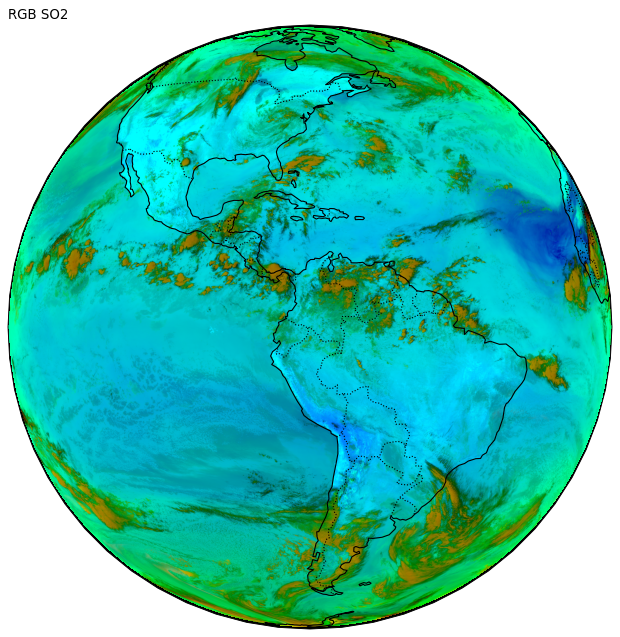

In [36]:
RGB = np.stack((R,G,B),axis=2)
plt.figure(figsize=(10,10))
ax  = plt.axes(projection=ccrs.Geostationary(central_longitude=lon_proj_origin,
                                             satellite_height=persp_height))
ax.coastlines()
ax.add_feature(BORDERS,ls=":")

ax.imshow(RGB,origin="upper",extent=img_extent)
ax.set_title(legend,loc="left")

# **Tarea 7: Crear un Compuesto RGB - "Night Microphysics"**

Guía Rápida RAMMB:
https://rammb.cira.colostate.edu/training/visit/quick_guides/QuickGuide_GOESR_NtMicroRGB_Final_20191206.pdf



In [37]:
bands = ["15","13","07"]
img1,img2,img3 = [xr.open_dataset(glob("data/OR_ABI-L2-CMIPF-M6C"+band+"_G16**.nc")[0]
                                       ,chunks="auto") for band in bands]

legend = "RGB Night Microphysics"
date = "202006181700" #YYYYMMDDHHMN

In [38]:
R = img1["CMI"]-img2["CMI"]
G = img2["CMI"]-img3["CMI"]
B = img2["CMI"]-273.15

Rmin,Rmax = -6.7,2.6
Gmin,Gmax = -3.1,5.2
Bmin,Bmax = -29.6,19.5

R = np.clip(R,Rmin,Rmax)
G = np.clip(G,Gmin,Gmax)
B = np.clip(B,Bmin,Bmax)

R = (R-Rmin)/(Rmax-Rmin)
G = (G-Gmin)/(Gmax-Gmin)
B = (B-Bmin)/(Bmax-Bmin)

Text(0.0, 1.0, 'RGB Night Microphysics')

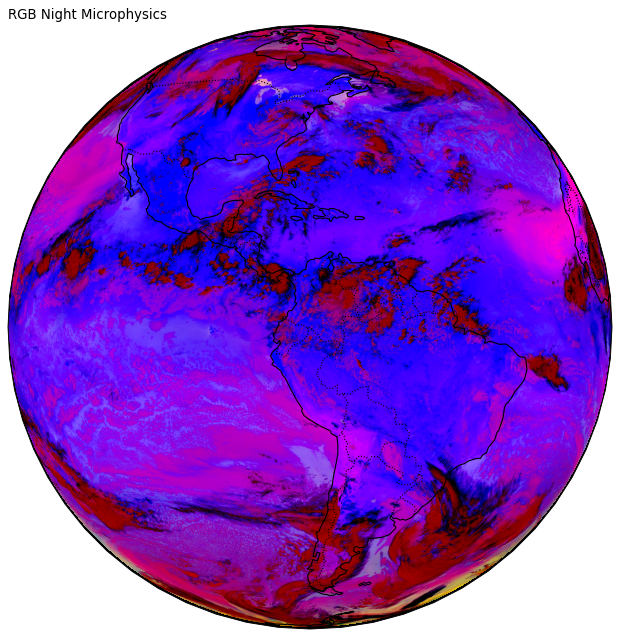

In [39]:
RGB = np.stack((R,G,B),axis=2)
plt.figure(figsize=(10,10))
ax  = plt.axes(projection=ccrs.Geostationary(central_longitude=lon_proj_origin,
                                             satellite_height=persp_height))
ax.coastlines()
ax.add_feature(BORDERS,ls=":")

ax.imshow(RGB,origin="upper",extent=img_extent)
ax.set_title(legend,loc="left")

# **Tarea 8: Crear un Compuesto RGB - "Day Land Cloud"**

Guía Rápida RAMMB:
https://rammb.cira.colostate.edu/training/visit/quick_guides/QuickGuide_GOESR_daylandcloudRGB_final.pdf



In [28]:
bands = ["05","03","02"]
img1,img2,img3 = [xr.open_dataset(glob("data/OR_ABI-L2-CMIPF-M6C"+band+"_G16**.nc")[0]
                                       ,chunks="auto") for band in bands]

legend = "RGB Dry Land Cloud"
date = "202006181700" #YYYYMMDDHHMN

In [29]:
R = img1["CMI"][::2,::2]
G = img2["CMI"][::2,::2]
B = img3["CMI"][::4,::4]

Rmin,Rmax = 0,0.975
Gmin,Gmax = 0,1.086
Bmin,Bmax = 0,1

R = np.clip(R,Rmin,Rmax)
G = np.clip(G,Gmin,Gmax)
B = np.clip(B,Bmin,Bmax)

R = (R-Rmin)/(Rmax-Rmin)
G = (G-Gmin)/(Gmax-Gmin)
B = (B-Bmin)/(Bmax-Bmin)

Text(0.0, 1.0, 'RGB Dry Land Cloud')

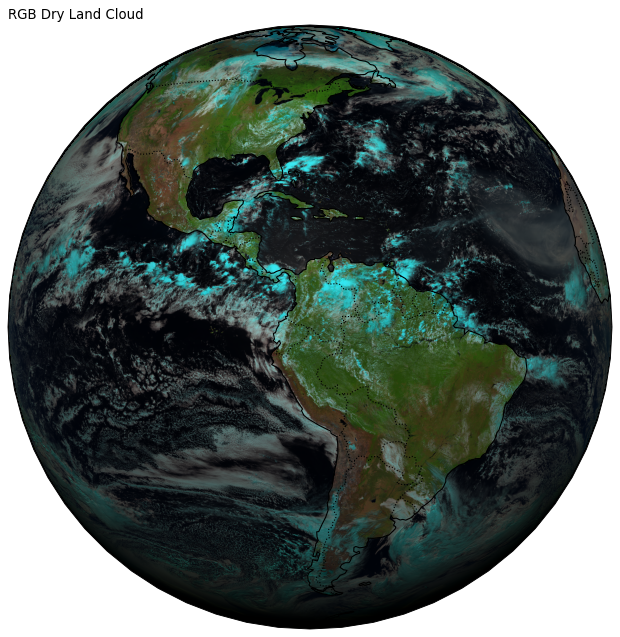

In [30]:
RGB = np.stack((R,G,B),axis=2)
plt.figure(figsize=(10,10))
ax  = plt.axes(projection=ccrs.Geostationary(central_longitude=lon_proj_origin,
                                             satellite_height=persp_height))
ax.coastlines()
ax.add_feature(BORDERS,ls=":")

ax.imshow(RGB,origin="upper",extent=img_extent)
ax.set_title(legend,loc="left")